## Generating the Data

In [1]:
import pandas as pd
import random
from faker import Faker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

In [2]:
# Initialize Faker instance
fake = Faker()

# Generate Customer Demographics Data
def generate_customer_demographics(num_customers=1000):
    customer_data = []
    for _ in range(num_customers):
        customer = {
            'customer_id': fake.uuid4(),
            'name': fake.name(),
            'age': random.randint(18, 70),
            'gender': random.choice(['Male', 'Female']),
            'marital_status': random.choice(['Single', 'Married', 'Divorced']),
            'education': random.choice(['High School', 'Bachelor', 'Master', 'PhD']),
            'occupation': fake.job(),
            'salary': random.randint(20000, 150000),  # Yearly salary
        }
        customer_data.append(customer)
    return pd.DataFrame(customer_data)

# Generate Customer Financial Behavior Data
def generate_financial_behavior(customer_ids, num_records=2000):
    financial_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        loan_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 150000)
        credit_limit = random.randint(1000, 150000) if product_type == 'Credit Card' else None
        utilization = random.uniform(0.1, 1.0) if product_type == 'Credit Card' else None
        max_dpd = random.choice([0, 15, 30, 60, 90, 120])
        default_status = random.choice([True, False])

        financial_behavior = {
            'customer_id': random.choice(customer_ids),
            'product_type': product_type,
            'loan_amount': loan_amount,
            'credit_limit': credit_limit,
            'credit_utilization': utilization,
            'emi_paid': random.randint(1, 24),
            'tenure_months': random.randint(12, 60),
            'max_dpd': max_dpd,
            'default_status': default_status
        }
        financial_data.append(financial_behavior)
    return pd.DataFrame(financial_data)

# Generate Customer Enquiries Data (Last 3 months)
def generate_customer_enquiries(customer_ids, num_records=500):
    enquiries_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        enquiry_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        enquiry = {
            'customer_id': random.choice(customer_ids),
            'enquiry_date': fake.date_between(start_date='-90d', end_date='today'),
            'product_type': product_type,
            'enquiry_amount': enquiry_amount,
            'status': random.choice(['Approved', 'Rejected'])
        }
        enquiries_data.append(enquiry)
    return pd.DataFrame(enquiries_data)

# Generate Customer Transaction Data (Past 6 months)
def generate_customer_transactions(customer_ids, num_records=5000):
    transactions_data = []
    for _ in range(num_records):
        transaction_date = fake.date_between(start_date='-180d', end_date='today')
        transaction_amount = random.uniform(50, 10000)
        
        # Transaction description with salary-related and hobby keywords
        transaction_description = random.choice([
            'Salary from XYZ Corp', 'Amazon Purchase', 'Grocery Store', 'Gym Membership',
            'Netflix Subscription', 'Restaurant', 'Fuel Station', 'Travel Booking', 
            'SALARY - ABC Corp', 'SAL credited from DEF Ltd', 'Monthly Salary GHI Pvt Ltd', 
            'Rent Payment', 'Car Insurance', 'Mobile Phone Bill', 'Electricity Bill', 'Spotify Subscription',
            'Uber Ride', 'Etsy Shopping', 'Concert Ticket', 'Books Purchase'
        ])

        # Salary detection
        salary_keywords = ['Salary', 'SALARY', 'SAL', 'SAL credited', 'Monthly Salary']
        is_salary = any(keyword in transaction_description.upper() for keyword in salary_keywords)

        # Hobbies detection based on transaction descriptions
        hobbies = None
        if "Amazon" in transaction_description or "Etsy" in transaction_description:
            hobbies = 'Shopping'
        elif "Netflix" in transaction_description or "Spotify" in transaction_description:
            hobbies = 'Entertainment'
        elif "Gym" in transaction_description:
            hobbies = 'Fitness'
        elif "Concert" in transaction_description:
            hobbies = 'Music'
        elif "Books" in transaction_description:
            hobbies = 'Reading'
        elif "Travel" in transaction_description or "Uber Ride" in transaction_description:
            hobbies = 'Travel'

        transaction = {
            'customer_id': random.choice(customer_ids),
            'transaction_date': transaction_date,
            'transaction_amount': transaction_amount,
            'transaction_description': transaction_description,
            'account_balance': random.uniform(500, 20000),
            'is_salary': is_salary,
            'hobby_detected': hobbies
        }
        transactions_data.append(transaction)

    return pd.DataFrame(transactions_data)

# Generate consistent data across all categories
customers = generate_customer_demographics(5000)
financial_behavior = generate_financial_behavior(customers['customer_id'], num_records=15000)
enquiries = generate_customer_enquiries(customers['customer_id'], num_records=4000)
transactions = generate_customer_transactions(customers['customer_id'], num_records=20000)

In [3]:
# Combine Data for Clustering
# Aggregating financial and transaction data by customer_id to create summary features
financial_summary = financial_behavior.groupby('customer_id').agg({
    'loan_amount': 'mean',
    'credit_limit': 'mean',
    'credit_utilization': 'mean',
    'emi_paid': 'sum',
    'tenure_months': 'mean',
    'max_dpd': 'max',
    'default_status': 'mean',
    'product_type':'unique'
}).reset_index()

transaction_summary = transactions.groupby('customer_id').agg({
    'transaction_amount': 'mean',
    'account_balance': 'mean',
    'is_salary': 'sum',
    'transaction_amount': lambda x: x[transactions['is_salary'] == 1].sum()
}).reset_index()

# Assuming 'enquiries' has columns like ['customer_id', 'product_type', 'enquiry_date', 'enquiry_amount']
enquiries_summary = enquiries.groupby('customer_id').agg({
    'enquiry_amount': 'mean',  # Average amount enquired
    'product_type': lambda x: x.nunique(),  # Number of unique products enquired
    'customer_id': 'count'  # Total number of enquiries
}).rename(columns={
    'customer_id': 'total_enquiries',
    'product_type': 'unique_products_enquired'
}).reset_index()

# Merging demographics, financial behavior, and transaction summary
merged_data = pd.merge(customers, financial_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, enquiries_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, transaction_summary, on='customer_id', how='left')

In [4]:
merged_data.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,tenure_months,max_dpd,default_status,product_type,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary
0,18c88442-1122-4a46-a386-b683728eab77,Megan Meyer,32,Male,Single,PhD,Hotel manager,39133,132304.666667,1844.0,...,36.000000,90.0,0.666667,"[Home Loan, Credit Card, Personal Loan]",92807.0,1.0,1.0,0.00000,8875.570743,0.0
1,f5fef3cc-bb71-48e9-8572-0f06ab705347,Stephen Robertson MD,20,Female,Married,PhD,Chartered public finance accountant,41227,253128.333333,111139.0,...,33.666667,90.0,0.333333,"[Personal Loan, Credit Card]",42608.0,1.0,1.0,1927.71239,9041.522424,1.0
2,8d737627-fe83-4628-b95d-b4f9dcc2b1e7,Lisa Dean,18,Male,Married,Bachelor,"Physicist, medical",56048,201605.000000,NaN,...,51.000000,90.0,0.000000,[Personal Loan],200488.0,2.0,2.0,0.00000,10344.881767,0.0
3,c4124b69-c760-4595-9b5a-6d8765581987,Michelle Perez,37,Male,Single,High School,"Civil engineer, consulting",131879,392634.000000,NaN,...,24.000000,0.0,0.000000,[Home Loan],NaN,NaN,NaN,0.00000,18724.633023,0.0
4,cc9a235a-abf8-4529-9496-0bc3095d5a2b,Ross White,53,Male,Married,High School,Health physicist,105053,274229.666667,NaN,...,43.333333,90.0,0.333333,[Personal Loan],NaN,NaN,NaN,0.00000,6712.399475,0.0


In [5]:
# Step 1: Explode the list in 'product_type' column
df_exploded = merged_data.explode('product_type')

# Step 2: One-hot encode the 'product_type' column
df_encoded = pd.get_dummies(df_exploded['product_type'])

merged_data = pd.concat([df_exploded, df_encoded], axis=1)

# Step 4: Group by the original index and aggregate to bring it back into one row per customer
df_final = merged_data.groupby(merged_data.index).sum()
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'product_type', 'enquiry_amount',
       'unique_products_enquired', 'total_enquiries', 'transaction_amount',
       'account_balance', 'is_salary', 'Credit Card', 'Home Loan',
       'Personal Loan'],
      dtype='object')

In [6]:
# Define the aggregation function for each column
aggregation_functions = {
    'customer_id': 'first',  # Keep first occurrence (assuming it's the same for the group)
    'name': 'first',         # Keep the first name in each group
    'age': 'mean',           # For age, you can take the average or median
    'gender': 'first',       # Assuming gender is the same within each group, take the first
    'marital_status': 'first', # Same for marital status
    'education': 'first',    # Same for education
    'occupation': 'first',   # Same for occupation
    'salary': 'sum',         # Sum numerical values like salary
    'loan_amount': 'sum',    # Sum numerical values like loan amount
    'credit_limit': 'sum',   # Sum numerical values like credit limit
    'credit_utilization': 'sum',
    'emi_paid':'sum',
    'tenure_months':'sum',
    'max_dpd':'max',
    'default_status':'max',
    'enquiry_amount': 'sum',
    'unique_products_enquired': 'sum',
    'total_enquiries': 'sum',
    'transaction_amount': 'sum',
    'account_balance': 'sum',
    'is_salary': 'mean',     # For boolean-like columns, you can take the mean (0 or 1)
    'Credit Card': 'max',    # For categorical (binary) features, take max (0 or 1)
    'Home Loan': 'max',
    'Personal Loan': 'max',
}

# Group by and apply aggregation functions
df_final = merged_data.groupby(merged_data.index).agg(aggregation_functions)
df_final.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan
0,18c88442-1122-4a46-a386-b683728eab77,Megan Meyer,32.0,Male,Single,PhD,Hotel manager,117399,396914.000000,5532.0,...,0.666667,278421.0,3.0,3.0,0.000000,26626.712228,0.0,True,True,True
1,f5fef3cc-bb71-48e9-8572-0f06ab705347,Stephen Robertson MD,20.0,Female,Married,PhD,Chartered public finance accountant,82454,506256.666667,222278.0,...,0.333333,85216.0,2.0,2.0,3855.424781,18083.044847,1.0,True,False,True
2,8d737627-fe83-4628-b95d-b4f9dcc2b1e7,Lisa Dean,18.0,Male,Married,Bachelor,"Physicist, medical",56048,201605.000000,0.0,...,0.000000,200488.0,2.0,2.0,0.000000,10344.881767,0.0,False,False,True
3,c4124b69-c760-4595-9b5a-6d8765581987,Michelle Perez,37.0,Male,Single,High School,"Civil engineer, consulting",131879,392634.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,18724.633023,0.0,False,True,False
4,cc9a235a-abf8-4529-9496-0bc3095d5a2b,Ross White,53.0,Male,Married,High School,Health physicist,105053,274229.666667,0.0,...,0.333333,0.0,0.0,0.0,0.000000,6712.399475,0.0,False,False,True


## Cluster the Data

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan'],
      dtype='object')


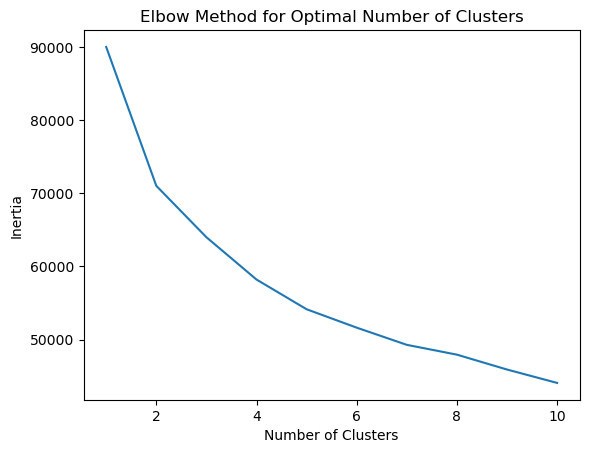

                            customer_id  customer_segment
0  18c88442-1122-4a46-a386-b683728eab77                 2
1  f5fef3cc-bb71-48e9-8572-0f06ab705347                 0
2  8d737627-fe83-4628-b95d-b4f9dcc2b1e7                 1
3  c4124b69-c760-4595-9b5a-6d8765581987                 1
4  cc9a235a-abf8-4529-9496-0bc3095d5a2b                 1


In [7]:
# Drop irrelevant columns for clustering
clustering_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
print(clustering_data.columns)
# Handle missing values
clustering_data.fillna(0, inplace=True)
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters (elbow method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal K (say K=4 based on the elbow curve)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['customer_segment'] = kmeans.fit_predict(scaled_data)

# View segmented data
print(df_final[['customer_id', 'customer_segment']].head())

In [8]:
pd.set_option('display.max_columns', None)
# Assuming df_final is your DataFrame and 'customer_segment' is the column to group by
float_columns = df_final.select_dtypes(include=['int','float'])
grouped_df = float_columns.groupby('customer_segment')

# Summary of each segment
segment_description = grouped_df.describe()
segment_description


age                                                      \
                   count       mean        std   min   25%   50%   75%   max   
customer_segment                                                               
0                 1659.0  44.223629  15.395784  18.0  31.0  44.0  58.0  70.0   
1                 2021.0  44.072736  15.281813  18.0  31.0  44.0  57.0  70.0   
2                 1320.0  43.969697  15.249474  18.0  31.0  44.0  57.0  70.0   

                  salary                                                   \
                   count           mean            std      min       25%   
customer_segment                                                            
0                 1659.0  203721.059675   96966.954603  40708.0  123657.5   
1                 2021.0  100911.388422   56293.476663  20009.0   59388.0   
2                 1320.0  220116.583333  107867.495288  41222.0  127132.0   

                                                loan_amount                 \
                       50%        75%       max       count           mean   
customer_segment                                                             
0                 198774.0  268092.50  449169.0      1659.0  432196.262573   
1                  93984.0  128957.00  299712.0      2021.0  234072.812821   
2                 211702.0  288587.25  449946.0      1320.0  491774.866029   

                                                                             \
                            std           min            25%            50%   
customer_segment                                                              
0                 192034.825693  29883.000000  287099.666667  418033.333333   
1                 194950.689991      0.000000   73152.000000  192574.500000   
2                 195361.002451  36258.666667  353356.050000  486735.750000   

                                         credit_limit                 \
                          75%        max        count           mean   
customer_segment                                                       
0                 558858.4125  1075108.2       1659.0  168850.292365   
1                 365557.0000   963919.0       2021.0   18372.658915   
2                 623163.3750  1062982.8       1320.0  174314.777588   

                                                                          \
                            std  min       25%            50%        75%   
customer_segment                                                           
0                 105912.914095  0.0  88873.00  163269.000000  236767.00   
1                  38397.654126  0.0      0.00       0.000000       0.00   
2                 121784.877332  0.0  74514.75  171700.916667  259558.25   

                           credit_utilization                           \
                       max              count      mean       std  min   
customer_segment                                                         
0                 445422.0             1659.0  1.227644  0.677102  0.0   
1                 298114.0             2021.0  0.131668  0.267695  0.0   
2                 449910.0             1320.0  1.210817  0.761558  0.0   

                                                        emi_paid              \
                      25%       50%       75%       max    count        mean   
customer_segment                                                               
0                 0.76618  1.201909  1.661499  2.999679   1659.0  114.117541   
1                 0.00000  0.000000  0.000000  1.996339   2021.0   29.747155   
2                 0.66380  1.244902  1.749605  2.995758   1320.0  131.458333   

                                                             tenure_months  \
                        std   min   25%    50%    75%    max         count   
customer_segment                                                             
0                 68.513354  10.0  64.0   96.0  149.0  423.0        1659.0   
1    

### Segment Descriptions:
1. **Segment 1: Affluent** :
Higher average salary, loan amount, credit limit, and transaction amounts. These customers have higher financial standing with substantial balances and engagement in high-value transactions.

2. **Segment 0: Cautious** :
Lower loan amounts and credit utilization, fewer enquiries, and lower transaction amounts. This segment seems to manage smaller finances and be more risk-averse or conservative in their credit usage.

3. **Segment 2: Moderate** :
Mid-range loan amounts, credit limits, and financial activity. They display a balanced financial profile with moderate usage across different financial metrics.

## Dynamic Pricing Model

In [9]:
# Preparing data for regression model (predicting loan amount)
# Drop non-numerical and unnecessary columns for regression
regression_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
regression_data.fillna(-888, inplace=True)

# Define models for each product type
rf_regressor_personal_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_home_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_credit_card = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model for Personal Loan
X_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)].drop(columns=['loan_amount'])
y_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)]['loan_amount']
X_train_personal_loan, X_test_personal_loan, y_train_personal_loan, y_test_personal_loan = train_test_split(X_personal_loan, y_personal_loan, test_size=0.2, random_state=42)
rf_regressor_personal_loan.fit(X_personal_loan, y_personal_loan)

# Train the model for Home Loan
X_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_home_loan, X_test_home_loan, y_train_home_loan, y_test_home_loan = train_test_split(X_home_loan, y_home_loan, test_size=0.2, random_state=42)
rf_regressor_home_loan.fit(X_train_home_loan, y_train_home_loan)

# Train the model for Credit Card
X_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_credit_card, X_test_credit_card, y_train_credit_card, y_test_credit_card = train_test_split(X_credit_card, y_credit_card, test_size=0.2, random_state=42)
rf_regressor_credit_card.fit(X_train_credit_card, y_train_credit_card)

# Predict on test set
y_pred = rf_regressor_credit_card.predict(X_test_credit_card)

# Evaluate the model
mse = mean_squared_error(y_test_credit_card, y_pred)
print(f"Mean Squared Error: {mse}")

# Example: Making predictions for a new customer
new_customer_data = X_test_credit_card.iloc[0:1]  # Select one customer data for testing
predicted_loan_amount = rf_regressor_credit_card.predict(new_customer_data)
print(f"Predicted Loan Amount: {predicted_loan_amount[0]}")

Mean Squared Error: 1711240208.0335057
Predicted Loan Amount: 68278.69333333333


## Product Recommendation Model

In [10]:
# Assuming df_final is already defined
# Preparing data for classification model
classification_data = df_final.copy()
classification_data.fillna(-888, inplace=True)
# Step 2: Drop unnecessary columns for the model and target columns
X_classification = classification_data.drop(columns=['customer_id', 'name', 'occupation', 'gender', 
                                                     'marital_status', 'education', 'Credit Card', 'Home Loan', 'Personal Loan'])
y_classification = classification_data[['Credit Card', 'Home Loan', 'Personal Loan']]  # Multi-output target columns

# Step 3: Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Initialize Random Forest Classifier with MultiOutputClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

# Step 5: Train the model on the training data for all three outputs
multi_target_classifier.fit(X_train_class, y_train_class)

# Step 6: Predict probabilities for the test set
y_prob_test = [estimator.predict_proba(X_test_class)[:, 1] for estimator in multi_target_classifier.estimators_]

# Combine probabilities into a DataFrame for easier handling
probabilities = pd.DataFrame({
    'Credit Card': y_prob_test[0],   # Probability for Credit Card
    'Home Loan': y_prob_test[1],     # Probability for Home Loan
    'Personal Loan': y_prob_test[2]  # Probability for Personal Loan
})

# Step 7: Find the most probable product for each customer
most_probable_product = probabilities.idxmax(axis=1)

# Optional: Evaluate model performance
y_pred = multi_target_classifier.predict(X_test_class)
print("\nClassification Report for Credit Card:")
print(classification_report(y_test_class['Credit Card'], y_pred[:, 0]))

print("\nClassification Report for Home Loan:")
print(classification_report(y_test_class['Home Loan'], y_pred[:, 1]))

print("\nClassification Report for Personal Loan:")
print(classification_report(y_test_class['Personal Loan'], y_pred[:, 2]))


Classification Report for Credit Card:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       388
        True       1.00      1.00      1.00       612

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Classification Report for Home Loan:
              precision    recall  f1-score   support

       False       0.70      0.56      0.62       384
        True       0.76      0.85      0.80       616

    accuracy                           0.74      1000
   macro avg       0.73      0.70      0.71      1000
weighted avg       0.73      0.74      0.73      1000


Classification Report for Personal Loan:
              precision    recall  f1-score   support

       False       0.71      0.70      0.70       398
        True       0.80      0.81      0.81       602

    accuracy                           0.77      1000
   macro

In [11]:
# Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
#        'occupation', 'salary', 'loan_amount', 'credit_limit',
#        'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
#        'default_status', 'product_type', 'enquiry_amount',
#        'unique_products_enquired', 'total_enquiries', 'transaction_amount',
#        'account_balance', 'is_salary', 'customer_segment'],
#       dtype='object')

X_classification.columns

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary',
       'customer_segment'],
      dtype='object')

### Save all the Models

In [12]:
import joblib

# Define the file paths for saving
model_paths = {
    'kmeans': 'E:/Abinash/2025/MyProject/models/kmeans_model.pkl',
    'scaler': 'E:/Abinash/2025/MyProject/models/scaler.pkl',
    'multi_target_classifier': 'E:/Abinash/2025/MyProject/models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'E:/Abinash/2025/MyProject/models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'E:/Abinash/2025/MyProject/models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'E:/Abinash/2025/MyProject/models/rf_regressor_credit_card_model.pkl'
}

# Save models to disk
joblib.dump(kmeans, model_paths['kmeans'])
joblib.dump(scaler, model_paths['scaler'])
joblib.dump(multi_target_classifier, model_paths['multi_target_classifier'])
joblib.dump(rf_regressor_personal_loan, model_paths['rf_regressor_personal_loan'])
joblib.dump(rf_regressor_home_loan, model_paths['rf_regressor_home_loan'])
joblib.dump(rf_regressor_credit_card, model_paths['rf_regressor_credit_card'])

print("Models saved successfully!")

Models saved successfully!


# Combined Code

In [13]:
model_paths = {
    'kmeans': 'E:/Abinash/2025/MyProject/models/kmeans_model.pkl',
    'scaler': 'E:/Abinash/2025/MyProject/models/scaler.pkl',
    'multi_target_classifier': 'E:/Abinash/2025/MyProject/models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'E:/Abinash/2025/MyProject/models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'E:/Abinash/2025/MyProject/models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'E:/Abinash/2025/MyProject/models/rf_regressor_credit_card_model.pkl'
}

kmeans = joblib.load(model_paths['kmeans'])
scaler = joblib.load(model_paths['scaler'])
multi_target_classifier = joblib.load(model_paths['multi_target_classifier'])
rf_regressor_personal_loan = joblib.load(model_paths['rf_regressor_personal_loan'])
rf_regressor_home_loan = joblib.load(model_paths['rf_regressor_home_loan'])
rf_regressor_credit_card = joblib.load(model_paths['rf_regressor_credit_card'])

print("Models loaded successfully!")


def process_customer_data(json_data, scaler):
    # Convert JSON data to a DataFrame
    customer_data = pd.DataFrame([json_data])
    
    # Drop columns not needed for clustering (based on your clustering model)
    clustering_data = customer_data
    
    # Handle missing values by replacing with 0 (or any appropriate strategy)
    clustering_data.fillna(0, inplace=True)
    
    scaled_data = scaler.transform(clustering_data)
    
    return customer_data, scaled_data

def predict_customer_segment(scaled_data, kmeans):
    # Predict the customer segment using your pre-trained KMeans model
    customer_segment = kmeans.predict(scaled_data)
    return customer_segment[0]

def recommend_product_and_loan(json_data, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card):
    # Convert JSON data to a DataFrame and scale the data
    customer_data, scaled_data = process_customer_data(json_data, scaler)

    # Step 1: Predict customer segment using KMeans
    customer_segment = predict_customer_segment(scaled_data, kmeans)
    
    # Add the predicted customer segment back to the customer_data DataFrame
    customer_data['customer_segment'] = customer_segment
    print(customer_data.columns)
    # Prepare for product recommendation using Random Forest Classifier
    X_classification_prod = customer_data.drop(columns=['Credit Card', 'Home Loan', 'Personal Loan'])
    X_classification_amt = customer_data
    
    # Step 2: Predict probabilities for each product using the multi-output classifier
    prob_credit_card = [estimator.predict_proba(X_classification_prod)[:, 1] for estimator in multi_target_classifier.estimators_]

    # Combine probabilities into a Series
    product_probabilities = pd.Series({
        'Credit Card': prob_credit_card[0][0],  # Since it's for one customer, we get the first value
        'Home Loan': prob_credit_card[1][0],
        'Personal Loan': prob_credit_card[2][0]
    })

    print(product_probabilities)
    
    # Identify the most probable product
    recommended_product = product_probabilities.idxmax()    
    recommended_probability = product_probabilities.max()

    recommendation = f"Recommended Product: {recommended_product} (Probability: {recommended_probability:.2f})"

    # Step 3: Predict loan amounts or credit limits based on the recommended product
    if recommended_product == 'Personal Loan':
        predicted_loan_amount_personal = rf_regressor_personal_loan.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_personal[0]:,.2f}"
    
    elif recommended_product == 'Home Loan':
        predicted_loan_amount_home = rf_regressor_home_loan.predict(X_classification_amt.drop(columns=['loan_amount']))  
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_home[0]:,.2f}"
    
    elif recommended_product == 'Credit Card':
        predicted_credit_limit = rf_regressor_credit_card.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Credit Limit: {predicted_credit_limit[0]:,.2f}"
    
    if recommended_probability < 0.5:
        recommendation = "No suitable product recommendations found for this customer."
    
    return recommendation, customer_segment, product_probabilities

# Example customer JSON data
example_json = {
    'age': 35, 'salary': 50000, 'loan_amount': 0, 'credit_limit': 10000, 
    'credit_utilization': 0.3, 'emi_paid': 1000, 'tenure_months': 12, 
    'max_dpd': 30, 'default_status': 0, 'enquiry_amount': 1000, 
    'unique_products_enquired': 3, 'total_enquiries': 5, 
    'transaction_amount': 5000, 'account_balance': 15000, 'is_salary': 1,
    'Credit Card': 1, 'Home Loan': 0, 'Personal Loan': 0, 
}

# Example usage:
recommend_product_and_loan(example_json, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card)

Models loaded successfully!
Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan', 'customer_segment'],
      dtype='object')
Credit Card      0.96
Home Loan        0.36
Personal Loan    0.28
dtype: float64


('Recommended Product: Credit Card (Probability: 0.96)\nPredicted Credit Limit: 81,271.95',
 np.int32(2),
 Credit Card      0.96
 Home Loan        0.36
 Personal Loan    0.28
 dtype: float64)

## Loading the LLM to generate Insights

In [14]:
import torch
import transformers
import langchain_huggingface
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain_huggingface import HuggingFacePipeline
from functools import lru_cache

@lru_cache(maxsize=None)
def load_model():
    model_name = "KingNish/Qwen2.5-0.5b-Test-ft"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

# Function to generate insights based on customer data
# Function to generate insights based on customer data
def generate_insights(customer_data):
    tokenizer, model = load_model()

    # Create a prompt from the customer data
    prompt = f"""
    Generate a personalized summarised insight about the following customer based on their data:
    
    - Name: {customer_data['name']}
    - Age: {customer_data['age']}
    - Gender: {customer_data['gender']}
    - Marital Status: {customer_data['marital_status']}
    - Education: {customer_data['education']}
    - Occupation: {customer_data['occupation']}
    - Salary: ${customer_data['salary']:,.2f}
    - Loan Amount: ${customer_data['loan_amount']:,.2f}
    - Credit Limit: ${customer_data['credit_limit']:,.2f}
    - Credit Utilization: {customer_data['credit_utilization']:.2%}
    - EMI Paid: {customer_data['emi_paid']}
    - Tenure Months: {round(float(customer_data['tenure_months']),2)}
    - Max DPD: {customer_data['max_dpd']}
    - Default Status: {int(customer_data['default_status'])}
    - Account Balance: ${customer_data['account_balance']:,.2f}

    Here are the Summarised Insights about {customer_data['name']}:
    """
    # Initialize the query pipeline with increased max_length
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        #max_length=6000,  # Increase max_length
        truncation=True,
        max_new_tokens=500,  # Control the number of new tokens generated
        device_map="auto",
    )

    llm = HuggingFacePipeline(pipeline=query_pipeline)

    insights = llm(prompt)
    
    return insights

In [15]:
import pandas as pd
import json

def df_row_to_json(row):
    data = row.to_dict()
    for key, value in data.items():
        if pd.isnull(value):
            data[key] = None
        elif isinstance(value, pd.Timestamp):
            data[key] = value.isoformat()

    # Convert to JSON string
    json_str = json.dumps(data, indent=4)
    return json_str

# Assuming `merged_data` is a DataFrame and we're converting row 8 to JSON
json_data_str = df_row_to_json(df_final.iloc[6])

# Now convert the JSON string back to a dictionary to access fields
json_data_dict = json.loads(json_data_str)

insights = generate_insights(json_data_dict)
print(json_data_str)
pd.DataFrame.from_dict(json_data_dict, orient='index').T

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Device set to use cpu
C:\Users\abina\AppData\Local\Temp\ipykernel_4256\194889340.py:56: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  insights = llm(prompt)


{
    "customer_id": "1646b68e-73d0-4528-a6e2-411dd13f4f47",
    "name": "Ashley King",
    "age": 50.0,
    "gender": "Female",
    "marital_status": "Divorced",
    "education": "PhD",
    "occupation": "Programmer, multimedia",
    "salary": 60150,
    "loan_amount": 233526.0,
    "credit_limit": 0.0,
    "credit_utilization": 0.0,
    "emi_paid": 16.0,
    "tenure_months": 14.0,
    "max_dpd": 90.0,
    "default_status": 0.0,
    "enquiry_amount": 69744.66666666667,
    "unique_products_enquired": 3.0,
    "total_enquiries": 3.0,
    "transaction_amount": 18325.23073890071,
    "account_balance": 10586.800196450164,
    "is_salary": 2.0,
    "Credit Card": false,
    "Home Loan": false,
    "Personal Loan": true,
    "customer_segment": 1
}


,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan,customer_segment
0,1646b68e-73d0-4528-a6e2-411dd13f4f47,Ashley King,50.0,Female,Divorced,PhD,"Programmer, multimedia",60150,233526.0,0.0,0.0,16.0,14.0,90.0,0.0,69744.666667,3.0,3.0,18325.230739,10586.800196,2.0,False,False,True,1


In [16]:
import re

# Function to clean unwanted characters and extract the insight
def clean_and_extract_insight(insights):
    # Remove unwanted characters (non-alphanumeric characters except spaces)
    cleaned_insight = re.sub(r'[^a-zA-Z0-9\s]', '', insights)
    
    # Extract the portion after "Summarised Insight"
    if "Here are the Summarised Insights about" in cleaned_insight:
        extracted_insight = cleaned_insight.split("Here are the Summarised Insights about")[1].strip().split("\n\n")[0]
    else:
        extracted_insight = cleaned_insight.strip()

    return extracted_insight

# Example usage
cleaned_insight = clean_and_extract_insight(insights)
print(cleaned_insight.strip())

Ashley King
      She is a female with a PhD and a career in programming
      She has a high salary of 6015000 and no credit utilization
      Her tenure months is 140
      She has not defaulted on her loan yet
      She has a maximum daily payment of 160
      She has not had any outstanding balance


In [17]:
data = cleaned_insight.split("\n")[1:]
all_data = list()
for line in data:
    all_data.append(line.strip())

all_data

['She is a female with a PhD and a career in programming',
 'She has a high salary of 6015000 and no credit utilization',
 'Her tenure months is 140',
 'She has not defaulted on her loan yet',
 'She has a maximum daily payment of 160',
 'She has not had any outstanding balance']